# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = (2. + \prod_i cos(\frac{\theta_i}{2})))^5$

and

$P(x) = \mathcal{U}[x \mid 0, 10]$.


In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import TerminationCondition
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO[2023-12-11 12:57:38,451]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 12:57:38,452]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 12:57:38,453]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 12:57:38,453]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:


ndim = 2


def log_likelihood(theta):
    return jnp.power(2. + jnp.prod(jnp.cos(0.5 * theta)), 5)


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros(ndim), high=jnp.pi * 10 * jnp.ones(ndim)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=236.04837036132812


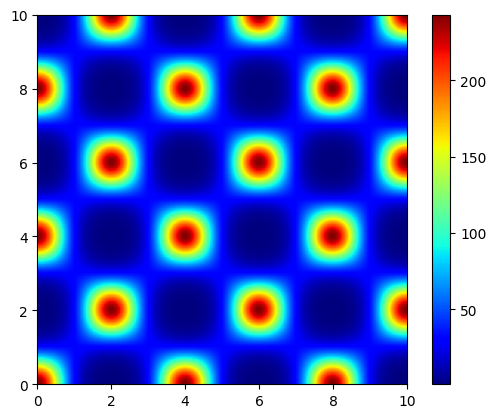

In [3]:
u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(lik, origin='lower', extent=(0., 10., 0., 10.), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model, max_samples=1e5)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [5]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
All live-points are on a single plateau (potential numerical errors, consider 64-bit)
--------
likelihood evals: 68635
samples: 1984
phantom samples: 832.0
likelihood evals / sample: 34.6
phantom fraction (%): 41.9%
--------
logZ=235.58 +- 0.29
H=inf
ESS=233.216064453125
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 17.9 +- 7.3 | 6.3 / 18.8 / 25.2 | 25.1 | 25.1
theta[1]: 15.6 +- 9.2 | 6.2 / 12.6 / 25.3 | 12.6 | 12.6
--------


WARNING[2023-12-11 12:57:45,771]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


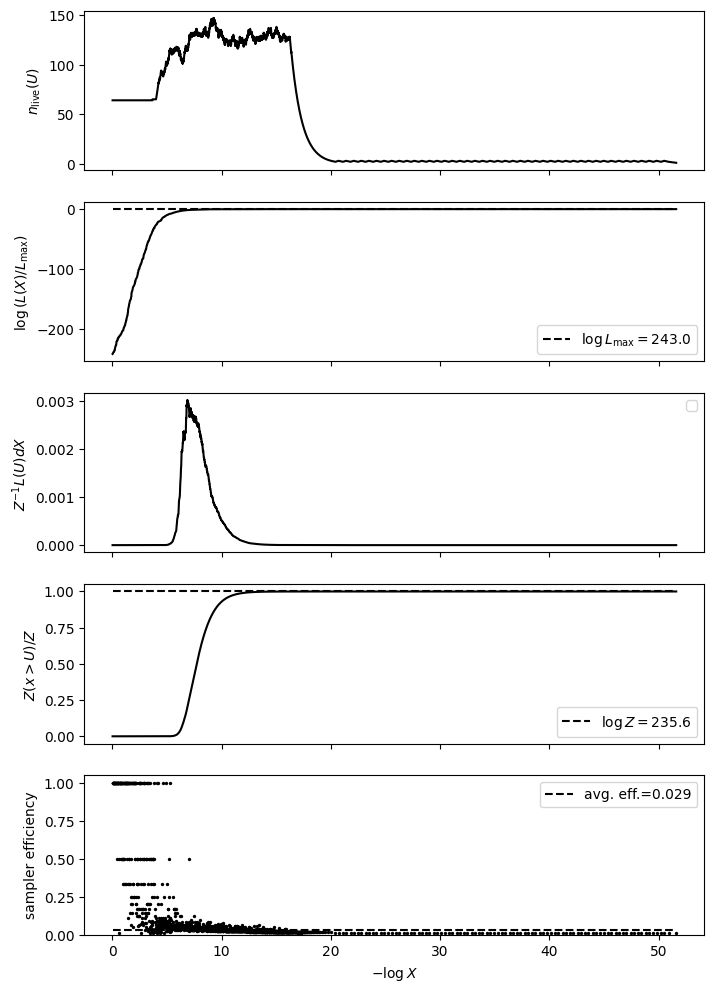

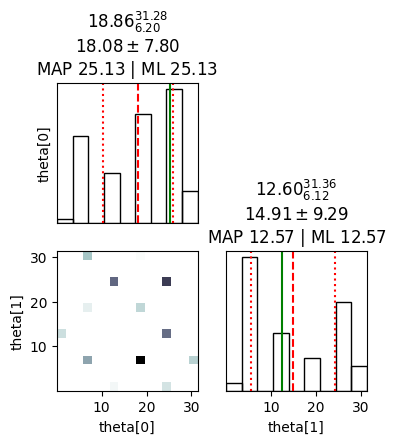

In [6]:
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)